In [2]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
from scipy.stats import norm

In [3]:
#c=e=em=mu=1, de0=1, we0=1
#function to initialize uniform slab of particles with density n0, temperature T0, 
#flow velocity V0, number of paricles NPIC (of e only), mass ratio MMI
def init_maxw(xmin=1.0, xmax=9.0, n0=1, T0=0.01, V0=0.0, NPIC=1000, MMI=100):
    xe=[]
    pex=[]
    pey=[]
    pez=[]
    xi=[]
    pix=[]
    piy=[]
    piz=[]    
    i=0
    while (i<NPIC):
        xe.append(xmin+(xmax-xmin)*random.random())
        while True:
            x=5*(random.random()-0.5)
            y=random.random()
            if(np.exp(-x*x)>=y):
                pex.append(2*np.sqrt(2*T0)*x)
                break
        while True:
            x=5*(random.random()-0.5)
            y=random.random()
            if(np.exp(-x*x)>=y):
                pey.append(2*np.sqrt(2*T0)*x)
                break
        while True:
            x=5*(random.random()-0.5)
            y=random.random()
            if(np.exp(-x*x)>=y):
                pez.append(2*np.sqrt(2*T0)*x)
                break
        while True:
            x=5*(random.random()-0.5)
            y=random.random()
            if(np.exp(-x*x)>=y):
                pix.append(2*np.sqrt(2*T0/MMI)*x)
                break
        while True:
            x=5*(random.random()-0.5)
            y=random.random()
            if(np.exp(-x*x)>=y):
                piy.append(2*np.sqrt(2*T0/MMI)*x)
                break
        while True:
            x=5*(random.random()-0.5)
            y=random.random()
            if(np.exp(-x*x)>=y):
                piz.append(2*np.sqrt(2*T0/MMI)*x)
                break
        i+=1
    xi=xe
    return xe, pex, pey, pez, xi, pix, piy, piz

#define shape function of the particle
def shapefunc(x, xpart):
    shapewidth=0.2 #in de0; CHANGE THIS!!!
    if (np.abs(x-xpart)<shapewidth):
        return 1.0
    else:
        return 0.0

#define charge and current deposition routine onto the grid
def rho_current_deposition(xe, pex, pey, pez, xi, pix, piy, piz, grid):
    rho=[0.0 for x in range(len(grid))]
    i=0
    while (i<len(grid)):
        xgrid=grid[i]
        for xx in xi:
            rho[i]+=shapefunc(xgrid, xx)
        for xx in xe:
            rho[i]-=shapefunc(xgrid, xx) #!!! normalization?    
        i+=1        
    return rho
#, current_x, current_y, current_z

#define field evolution routine: electrostatic to start with

def field_evolution_es(ex,ey,ez,grid,rho,dt):
    kx=[2*np.pi*i/(grid[-1]-grid[0]) for i in range(len(grid))]
    rhofft=np.fft.fft(rho)
    print(len(grid))
    exfft=np.array(len(grid),dtype=complex)
    for i in range(len(grid)):
        print(i)
        if(i!=0):
            exfft[i]=rho[i]*(len(grid)*grid[1]-grid[0])/(2*np.pi*i)
    
    
    # exfft=[-4*np.pi*1j*x/y for x,y in zip(rhofft,kx)]
    exfft[0]=0.0
    exnew=np.fft.ifft(exfft)
    eynew=rho
    eznew=rho
    
    return exnew,eynew,eznew

#define particle pushing routine, leapfrog scheme

def push_particles(ex, ey, ez, xe, pex, pey, pez, xi, pix, piy, piz, grid, dt, MMI):
    #iterate over all electrons
    for i in range(len(xe)):
        Fx=0
        Fy=0
        Fz=0

        #collect Fx onto the particle i from all grid cells
        for k in range(len(grid)):
            Fx+=ex[k]*shapefunc(grid[k],xe[i])

        #push particle 
        pex[i]-=0.5*dt*Fx #now it is pex at 1/2 step
        xe[i]+=dt*pex[i]
        
        #recalculate coordinate if particle is away from the grid after the push
        if (xe[i]<grid[0]):
            xe[i]=grid[-1]+xe[i]-grid[0]
        if (xe[i]>grid[-1]):
            xe[i]=-grid[-1]+xe[i]+grid[0]

    #iterate over all ions
    for i in range(len(xi)):
        Fx=0
        Fy=0
        Fz=0
        
        #collect Fx onto the particle i from all grid cells
        for k in range(len(grid)):
            Fx+=ex[k]*shapefunc(grid[k],xi[i])
        
        #push particle 
        pix[i]+=0.5*dt*Fx/MMI
        xi[i]+=dt*pix[i]
        
        #recalculate coordinate if particle is away from the grid after the push        
        if (xi[i]<grid[0]):
            xi[i]=grid[-1]+xi[i]-grid[0]
        if (xi[i]>grid[-1]):
            xi[i]=-grid[-1]+xi[i]+grid[0]
        
    return xe, pex, pey, pez, xi, pix, piy, piz

#define a function that pushes velocities from i+1/2 to i+1 timestep

def fix_velocities(ex, ey, ez, xe, pex, pey, pez, xi, pix, piy, piz, grid, dt, MMI):
    #iterate over all electrons
    for i in range(len(xe)):
        Fx=0
        Fy=0
        Fz=0

        #collect Fx onto the particle i from all grid cells
        for k in range(len(grid)):
            Fx+=ex[k]*shapefunc(grid[k],xe[i])

        #push particle 
        pex[i]-=0.5*dt*Fx #now it is pex at 1/2 step
        
    #iterate over all ions
    for i in range(len(xi)):
        Fx=0
        Fy=0
        Fz=0
        
        #collect Fx onto the particle i from all grid cells
        for k in range(len(grid)):
            Fx+=ex[k]*shapefunc(grid[k],xi[i])
        
        #push particle 
        pix[i]+=0.5*dt*Fx/MMI
            
    
    return pex, pey, pez, pix, piy, piz




In [58]:
#initialize simulation
dt=0.05 #0.01* wpe0^-1
Tfinish=1 #10* wpe0^-1
xmin=0.0 #zero de0
xmax=10.0 #ten de0
T0=0.05 # in dim units
n0=1 # in dim units
Nsteps=int(Tfinish/dt)
Ngrid=100 #number of grid cells
MMI=100 #mass ratio
grid=[xmin+i*xmax/Ngrid for i in range(Ngrid)]
ex=[0.0 for i in range(Ngrid)]
ey=[0.0 for i in range(Ngrid)]
ez=[0.0 for i in range(Ngrid)]
[xe, pex, pey, pez, xi, pix, piy, piz] = init_maxw(xmin=0.0, xmax=10.0, n0=n0, T0=T0, V0=0.0, NPIC=1000, MMI=2000)


if(dt>(xmax-xmin)/Ngrid):
    print("CFL > 1, integrator is unstable!")
    
if(np.sqrt(T0/n0)<(xmax-xmin)/Ngrid):
    print("Warning! Debye length is not resolved!")

i=0
while (i<Nsteps):
#    plt.hist(pex,20)
#    plt.show()
    mu, std = norm.fit(pex)
    print("Nstep=",str(i+1), ", time=",str(int((i+1)*dt*1000)/1000), "wpe0^-1, Tex=",str(int(std*std/2.0*10000)/10000))
    [xe, pex, pey, pez, xi, pix, piy, piz] = push_particles(ex, ey, ez, xe, pex, pey, pez, xi, pix, piy, piz, grid, dt, MMI)
    rho = rho_current_deposition(xe, pex, pey, pez, xi, pix, piy, piz,grid)
    [ex,ey,ez] = field_evolution_es(ex,ey,ez,grid,rho,dt)
    [pex, pey, pez, pix, piy, piz] = fix_velocities(ex, ey, ez, xe, pex, pey, pez, xi, pix, piy, piz, grid, dt, MMI)
#    plt.plot(grid,ex)
#    plt.show()
    i+=1

Nstep= 1 , time= 0.05 wpe0^-1, Tex= 0.0964


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in cdouble_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: ComplexWarning: Casting complex values to real discards the imaginary part


Nstep= 2 , time= 0.1 wpe0^-1, Tex= 0.0964
Nstep= 3 , time= 0.15 wpe0^-1, Tex= 0.0964
Nstep= 4 , time= 0.2 wpe0^-1, Tex= 0.0964
Nstep= 5 , time= 0.25 wpe0^-1, Tex= 0.0964
Nstep= 6 , time= 0.3 wpe0^-1, Tex= 0.0964
Nstep= 7 , time= 0.35 wpe0^-1, Tex= 0.0964
Nstep= 8 , time= 0.4 wpe0^-1, Tex= 0.0964
Nstep= 9 , time= 0.45 wpe0^-1, Tex= 0.0964
Nstep= 10 , time= 0.5 wpe0^-1, Tex= 0.0964
Nstep= 11 , time= 0.55 wpe0^-1, Tex= 0.0964
Nstep= 12 , time= 0.6 wpe0^-1, Tex= 0.0964
Nstep= 13 , time= 0.65 wpe0^-1, Tex= 0.0964
Nstep= 14 , time= 0.7 wpe0^-1, Tex= 0.0964
Nstep= 15 , time= 0.75 wpe0^-1, Tex= 0.0964
Nstep= 16 , time= 0.8 wpe0^-1, Tex= 0.0964
Nstep= 17 , time= 0.85 wpe0^-1, Tex= 0.0964
Nstep= 18 , time= 0.9 wpe0^-1, Tex= 0.0964
Nstep= 19 , time= 0.95 wpe0^-1, Tex= 0.0964
Nstep= 20 , time= 1.0 wpe0^-1, Tex= 0.0964


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  


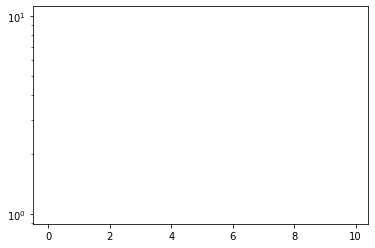

In [42]:
plt.plot(grid,ex)
plt.yscale("log")

In [95]:
len([i for i in range(100)])

100

In [30]:
[xe, pex, pey, pez, xi, pix, piy, piz] = init_maxw(xmin=2.0, xmax=8.0, n0=1, T0=0.02, V0=0.0, NPIC=100, MMI=2000)

(array([  4.,   2.,   7.,  16.,  23.,  51.,  75.,  85., 104., 107., 133.,
        129.,  82.,  66.,  52.,  32.,  16.,   9.,   4.,   3.]),
 array([-1.39809584e+00+0.j, -1.25817847e+00+0.j, -1.11826111e+00+0.j,
        -9.78343751e-01+0.j, -8.38426389e-01+0.j, -6.98509027e-01+0.j,
        -5.58591666e-01+0.j, -4.18674304e-01+0.j, -2.78756942e-01+0.j,
        -1.38839580e-01+0.j,  1.07778142e-03+0.j,  1.40995143e-01+0.j,
         2.80912505e-01+0.j,  4.20829867e-01+0.j,  5.60747228e-01+0.j,
         7.00664590e-01+0.j,  8.40581952e-01+0.j,  9.80499314e-01+0.j,
         1.12041668e+00+0.j,  1.26033404e+00+0.j,  1.40025140e+00+0.j]),
 <a list of 20 Patch objects>)

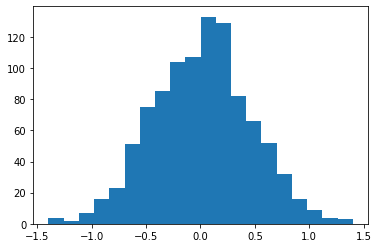

In [47]:
plt.hist(pex,20)

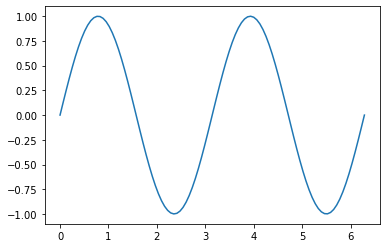

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in cdouble_scalars
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in cdouble_scalars
  if __name__ == '__main__':


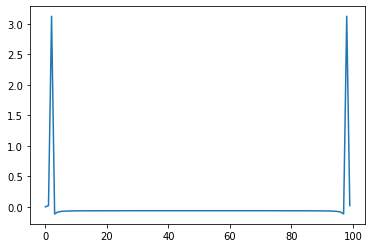

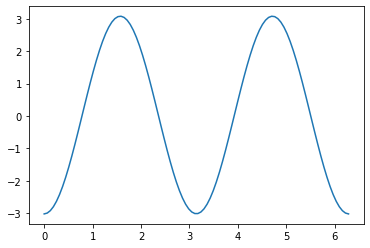

In [51]:
x=np.linspace(0,2*np.pi,100)
y=np.sin(2*x)
kx=[i for i in range(100)]
plt.plot(x,y)
plt.show()
yfft=np.fft.fft(y)
#yfft[-1]=0.0
plt.plot(yfft)
yfftdiv=[-4*np.pi*1j*x/y for x,y in zip(yfft,kx)]
yfftdiv[0]=0.0
#plt.xscale("log")
#plt.yscale("log")
plt.show()
ybackdiv=np.fft.ifft(yfftdiv)
plt.plot(x,ybackdiv)
plt.show()

nx=16
16


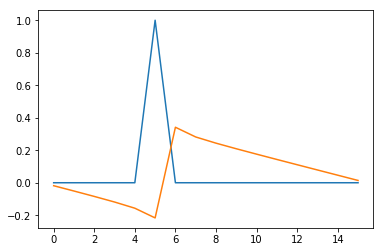

In [47]:
grids=np.arange(16)
#rho=np.sin(8*3.1415926/128*grids)

rho=np.zeros(16)

rho[5]=1.0
#rho[20]=-1
# ex=rho
# ey=rho
#  ez=rho

def gauss(rho,dx=1,shift=0):
    
    nx = len(rho)
    lx=dx*float(nx)
    print('nx='+repr(nx))
    rho_i = np.fft.fft(rho)
    
    ex_i=rho_i
    print(len(ex_i))
    for i in range(nx):
        if (i!=0):
            k_val=2*np.pi*float(i)/lx
            k_val_i=lx/(2.0*np.pi*float(i))
            ex_i[i]=-rho_i[i]*complex(0,1)*k_val_i*np.exp(complex(0,1)*k_val*dx*shift)
    
    ex=np.fft.ifft(ex_i)
    
    return(ex)
        
ex= gauss(rho,shift=-0.5)
plt.plot(grids,rho)
plt.plot(grids,ex)

In [9]:
import os
import re
import shutil
import subprocess
import IPython.display
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from ipywidgets import interact, fixed
from scipy.optimize import fsolve
import scipy

from scipy import special
import cmath
import mpmath

def fluidw(k, vth, mr):
    c_s = (np.sqrt(vth/mr))
    k_De = 1
    w = k*k_De*c_s/np.sqrt(1+(k)**2)
    return w

def zfunc(z):
    a = special.wofz(z)
    a *= np.sqrt(np.pi)*complex(0,1)
    return a


def zprime(z):

## the line below is needed for the root finder, which uses MP (multi-precision) variables
## instead of real and/or complex, so the first step is to convert the variable "z" from
## of a type

    arg= complex(z.real,z.imag)
    value= zfunc(arg)
    return(-2*(1+z*value))


def landauKinetic(karray, Mratio, Tratio):

    nk=karray.shape[0]

    results=np.zeros(nk)
    results_r = np.zeros(nk)

    kmin=karray[0]
    kmax=karray[nk-1]
    print('we are here')
    if (kmin!=0.0):
        # root_trial=complex(fluidw(0.01,1,Mratio),0)
        root_trial=0
        newroot=0
        for k_val in np.arange(0.01,kmin,0.01):
            root_trial=complex(fluidw(k_val,1.0,Mratio),0)
            print(root_trial,k_val,k_val/np.sqrt(Mratio))
            print(newroot)
            def epsilon(omega):
                #return (1-0.5*((1.0/k_val)**2)*zprime(omega/(np.sqrt(2)*k_val))-0.5*
                #       ((1/np.sqrt(Mratio)/(k_val*np.sqrt(Tratio/Mratio))))*
                #        zprime(omega/(np.sqrt(2)*k_val*np.sqrt(Tratio/Mratio))))
                return (1-(1.0/k_val)**2-0.5*
                       ((1/np.sqrt(Mratio)/(k_val*np.sqrt(Tratio/Mratio))))*
                        zprime(omega/(np.sqrt(2)*k_val*np.sqrt(Tratio/Mratio))))
            newroot=mpmath.findroot(epsilon,root_trial,solver='muller')
            root_trial=complex(fluidw(k_val,1,Mratio),0)

        results[0]=newroot.imag
    else:
        results[0]=0.0
        newroot=complex(0.1,0)
        root_trial=complex(0.1,0)


    for i_mode in range(1,nk):
        print(i_mode)
        k_val=karray[i_mode]
        def epsilon(omega):
                return(1-(1.0/k_val)**2-0.5*
                      ((1/np.sqrt(Mratio)/(k_val*np.sqrt(Tratio/Mratio))))*
                       zprime(omega/(np.sqrt(2)*k_val*np.sqrt(Tratio/Mratio))))
        newroot=mpmath.findroot(epsilon,root_trial,solver='muller')
        # newroot=scipy.optimize.newton(epsilon,root_trial)
        root_trial=complex(fluidw(k_val,1,Mratio),0)
        results[i_mode]=newroot.imag
        results_r[i_mode] = newroot.real

    return results, results_r

In [13]:
karray=np.arange(0.0,0.01,0.001)
[damping,freq] = landauKinetic(karray,2000,0.0001)

we are here
1
2
3
4
5
6
7
8
9


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in cdouble_scalars


In [14]:
print(freq)

[ 0. nan nan nan nan nan nan nan nan nan]
